To look at FD and motion correction parameters for subjects in bulk:

In [1]:
# get subjects from subjects.txt:
# Path to your subject list file
subjects_file = r"D:\HCP_vessel_files\subjects.txt"

# Read all IDs into a Python list
with open(subjects_file, "r") as f:
    subjects = [line.strip() for line in f if line.strip()]

print("Loaded", len(subjects), "subjects:")
# print(subjects[:30])  # show the first 10 to check
# subjects = subjects


Loaded 190 subjects:


In [2]:
# Check which subjects have been done already:



In [4]:
import numpy as np
import pandas as pd
import os

results = []  # to store metrics for all subjects

for subjectid in subjects:
    print(f"subject {subjectid}")
    output_dir = fr"D:\hcp_processed\{subjectid}\motion_corrected"

    motion_path = os.path.join(output_dir, "motion_array.npy")
    if not os.path.exists(motion_path):
        print(f"⚠️ No motion file for {subjectid}, skipping.")
        continue

    # load motion array
    motion_array = np.load(motion_path)

    # compute FD (Power et al., 2012)
    disp = np.abs(np.diff(motion_array, axis=0))
    fd = np.sum(disp[:, :3], axis=1) + np.sum(disp[:, 3:] * (np.pi/180 * 50), axis=1)

    mean_fd = np.mean(fd)
    percent_high_fd = np.mean(fd > 0.5) * 100

    # Here is where we decide who to exclude: 
    # exclude = (percent_high_fd > 20) or (mean_fd > 0.2)
    exclude = (percent_high_fd > 20) or (mean_fd > 0.3)

    results.append({
        "subjectid": subjectid,
        "mean_fd": mean_fd,
        "percent_high_fd": percent_high_fd,
        "exclude": exclude
    })

# convert to DataFrame
df = pd.DataFrame(results)
print(df.head())

# save to CSV
df.to_csv(r"D:\hcp_processed\fd_summary.csv", index=False)
print("✅ Saved FD summary to D:\\hcp_processed\\fd_summary.csv")


subject 100307
subject 101309
subject 102008
subject 102311
subject 103111
subject 103414
subject 103818
subject 105014
subject 107422
subject 108828
subject 109123
subject 110411
subject 111716
subject 113619
subject 113821
subject 113922
subject 114419
subject 115320
subject 116524
subject 118528
subject 118932
subject 120212
subject 121618
subject 123420
subject 124220
subject 124826
subject 127630
subject 128127
subject 129533
subject 130013
subject 132118
subject 133827
subject 136833
subject 137027
subject 137128
subject 137936
subject 138231
subject 140117
subject 140824
subject 142424
subject 142828
subject 143325
subject 144832
subject 145531
subject 146331
subject 146432
subject 148941
subject 150423
subject 150726
subject 151627
subject 153833
subject 154734
subject 154936
subject 155635
subject 156637
subject 158035
subject 159138
subject 161630
subject 161731
subject 162733
subject 163331
subject 164131
subject 165032
subject 167743
subject 168341
subject 169343
subject 16

In [5]:
# df = pd.read_csv(r"C:\DocumentsPC\DATA\HCP\unrestricted_cm15_4_22_2025_11_11_54.csv")
info = pd.read_csv(r"C:\DocumentsPC\DATA\HCP\unrestricted_cm15_4_22_2025_11_11_54.csv")
# merged = info.merge(df, on="subjectid", how="left")
info['Subject'] = info['Subject'].astype(str)
df['subjectid'] = df['subjectid'].astype(str)
merged = info.merge(df, left_on="Subject", right_on="subjectid", how="left")

# merged.to_csv(r"D:\hcp_processed\subject_info_with_fd.csv", index=False)
# print("✅ Merged FD data with subject info")


In [6]:
import scipy.stats as stats

# assume column 'group' has two groups: 'control' and 'patient'
group1 = merged[merged['Gender'] == 'M']['mean_fd']
group2 = merged[merged['Gender'] == 'F']['mean_fd']

t, p = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Group FD difference: t = {t:.3f}, p = {p:.4f}")


Group FD difference: t = 0.528, p = 0.5981


Total subjects: 190
Excluded subjects: 10 (5.3%)


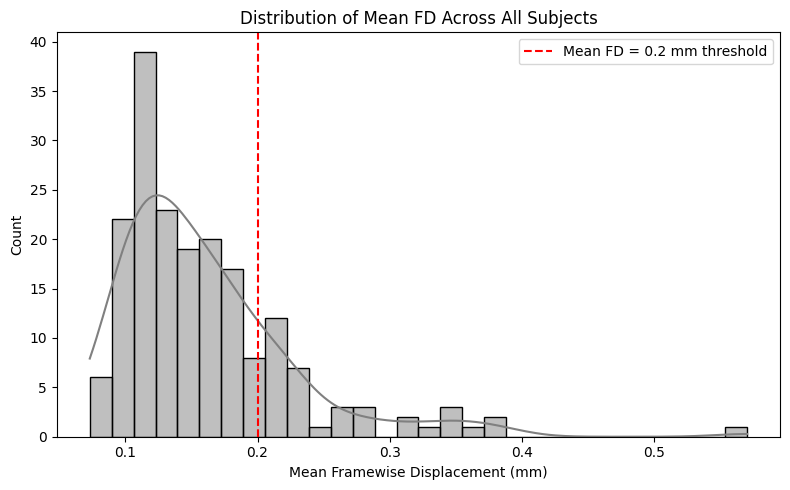

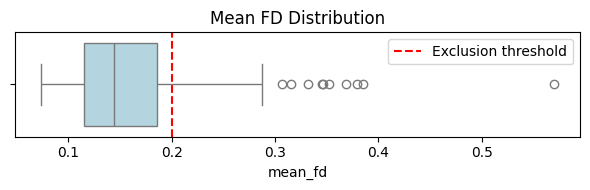

In [ ]:
# Look at distribution of scores

total_subjects = len(df)
excluded_subjects = df['exclude'].sum()
print(f"Total subjects: {total_subjects}")
print(f"Excluded subjects: {excluded_subjects} ({excluded_subjects/total_subjects*100:.1f}%)")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['mean_fd'], bins=30, kde=True, color='gray')
plt.axvline(0.3, color='red', linestyle='--', label='Mean FD = 0.2 mm threshold')
plt.xlabel("Mean Framewise Displacement (mm)")
plt.ylabel("Count")
plt.title("Distribution of Mean FD Across All Subjects")
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,2))
sns.boxplot(x=df['mean_fd'], color='lightblue')
plt.axvline(0.2, color='red', linestyle='--', label='Exclusion threshold')
plt.title("Mean FD Distribution")
plt.legend()
plt.tight_layout()
plt.show()




Other motion parameters:

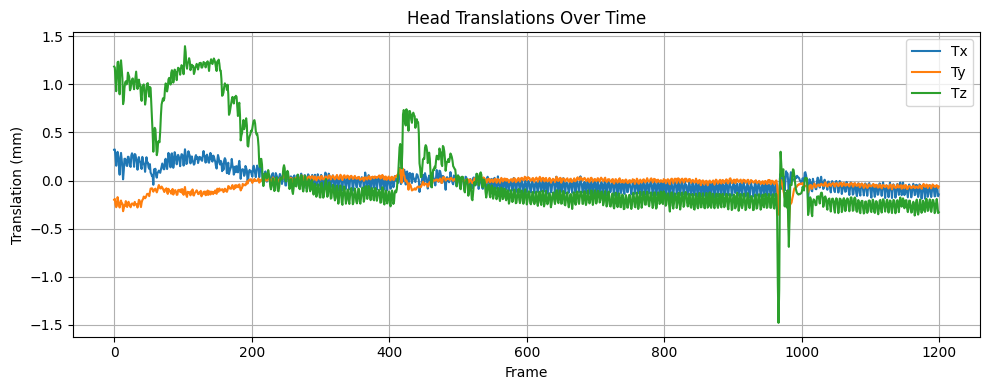

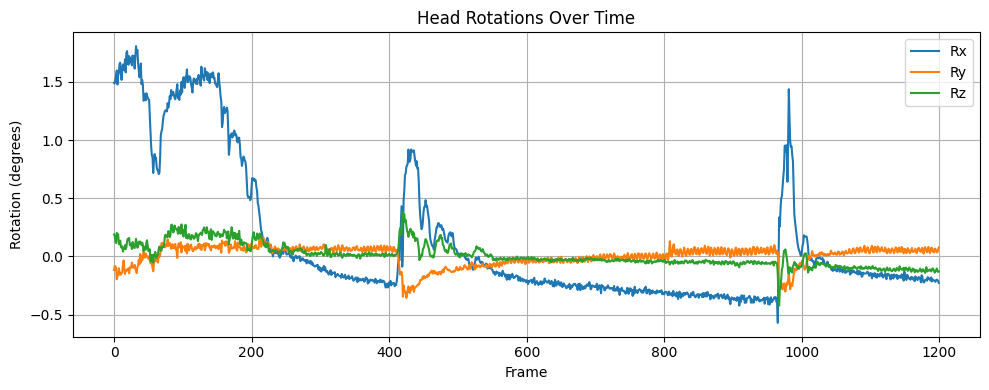

In [8]:
# May also want to plot the parameters themselves and their FFT:
import numpy as np
import matplotlib.pyplot as plt

# Assuming motion_array is already defined:
# motion_array.shape = (n_timepoints, 6)
# Columns: Tx, Ty, Tz, Rx, Ry, Rz

translations = motion_array[:, :3]  # mm
rotations = motion_array[:, 3:]    # degrees

# Plot translations
plt.figure(figsize=(10, 4))
plt.plot(translations)
plt.legend(['Tx', 'Ty', 'Tz'])
plt.ylabel("Translation (mm)")
plt.title("Head Translations Over Time")
plt.xlabel("Frame")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot rotations
plt.figure(figsize=(10, 4))
plt.plot(rotations)
plt.legend(['Rx', 'Ry', 'Rz'])
plt.ylabel("Rotation (degrees)")
plt.title("Head Rotations Over Time")
plt.xlabel("Frame")
plt.grid(True)
plt.tight_layout()
plt.show()





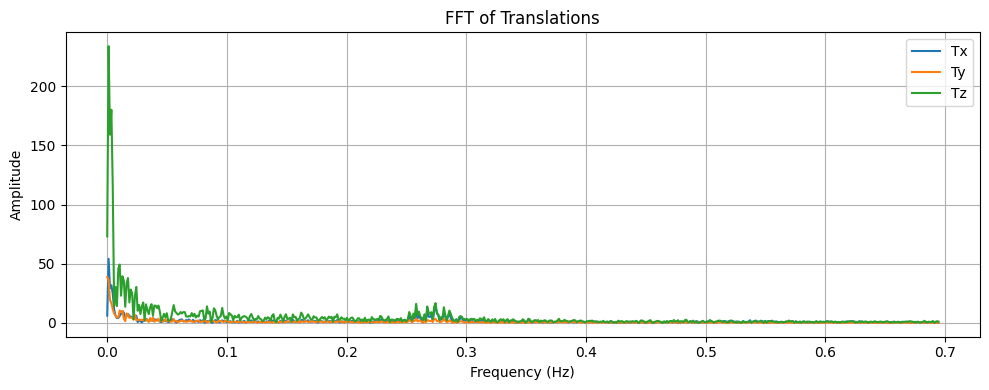

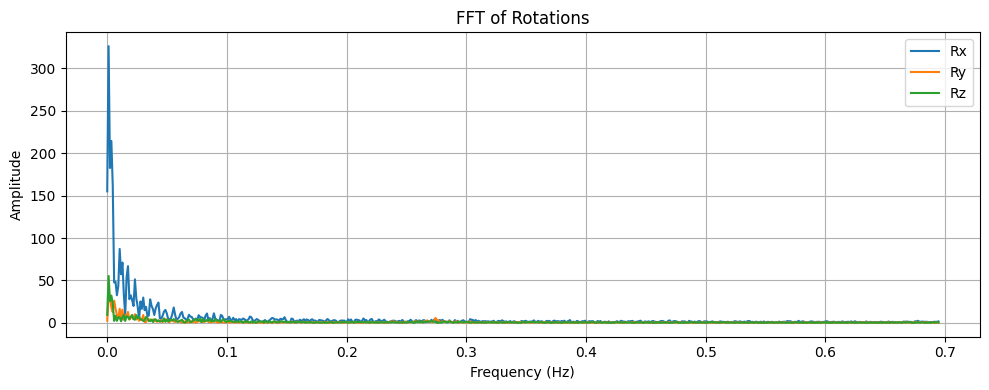

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assume motion_array is already defined (shape: [n_frames, 6])
translations = motion_array[:, :3]  # Tx, Ty, Tz
rotations = motion_array[:, 3:]    # Rx, Ry, Rz

# Sampling parameters
TR = 0.72  # seconds
fs = 1 / TR  # sampling frequency
n = motion_array.shape[0]  # number of timepoints
freqs = np.fft.rfftfreq(n, d=TR)  # frequency bins

# Compute FFTs
trans_fft = np.abs(np.fft.rfft(translations, axis=0))
rot_fft = np.abs(np.fft.rfft(rotations, axis=0))

# Plot translation FFTs
plt.figure(figsize=(10, 4))
plt.plot(freqs, trans_fft)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Translations")
plt.legend(['Tx', 'Ty', 'Tz'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot rotation FFTs
plt.figure(figsize=(10, 4))
plt.plot(freqs, rot_fft)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Rotations")
plt.legend(['Rx', 'Ry', 'Rz'])
plt.grid(True)
plt.tight_layout()
plt.show()
